# Packages

## Install POT

In [1]:
!pip install POT
!pip install --upgrade numpy

Requirement already up-to-date: numpy in /opt/anaconda3/lib/python3.8/site-packages (1.22.2)


## Install gudhi + optmizer packages

In [ ]:
!pip install gudhi

     |████████████████████████████████| 29.3 MB 1.4 MB/s 


In [ ]:

!pip install tensorflow_addons
!pip install git+https://github.com/master/tensorflow-riemopt.git

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
  Cloning https://github.com/master/tensorflow-riemopt.git to /tmp/pip-req-build-tdrgndo0
  Running command git clone -q https://github.com/master/tensorflow-riemopt.git /tmp/pip-req-build-tdrgndo0
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 5.6 MB 40.7 MB/s 
     |████████████████████████████████| 14.8 MB 37.3 MB/s 
     |████████████████████████████████| 1.3 MB 27.5 MB/s 
     |████████████████████████████████| 462 kB 55.0 MB/s 
     |████████████████████████████████| 132 kB 28.2 MB/s 
  Created wheel for tensorflow-riemopt: filename=tensorflow_riemopt-0.1.0-py3-none-any.whl size=45244 sha256=7b10fed5ccd1420fddcbb2b26f591e718f1bcf926cc907982feb887ac8d542a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-jt91spdx/wheels/f5/3c/6c/a6eebf4b391b6af4cb01f873345d494c35c02b3883636d1a94
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=d28225e5b3fccf7

In [ ]:
!pip install eagerpy

## Import

In [2]:
import numpy               as np
import tensorflow_addons   as tfa
import tensorflow          as tf
import matplotlib.pyplot   as plt
import pandas              as pd
import gudhi               as gd
import keras.backend as K

from gudhi.wasserstein     import wasserstein_distance
from mpl_toolkits.mplot3d  import Axes3D
from sklearn.metrics       import pairwise_distances


#import tensorflow_riemopt as manopt
import ot #pot

#import tensorflow_manopt as manopt <---- didn't work. ??

#from scipy.stats import wasserstein_distance

In [42]:
# import packages
import scipy
from scipy.stats import norm 
import time
import statsmodels.api as sm
import math
#from scipy.cluster.vq import whiten
from tensorflow.keras import initializers

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import normalize
from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model

In [5]:
from data_generation import *

## Original Rips Model

In [6]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

class RipsModel(tf.keras.Model):
    def __init__(self, P, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        #Z=X@self.P
        Z=self.P
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

## Modified RipsModel

In [26]:
def Rips(DX, mel, dim, card):
    # Parameters: DX (distance matrix), 
    #             mel (maximum edge length for Rips filtration), 
    #             dim (homological dimension), 
    #             card (number of persistence diagram points, sorted by distance-to-diagonal)

    # Compute the persistence pairs with Gudhi
    rc = gd.RipsComplex(distance_matrix=DX, max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=dim+1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()

    # Retrieve vertices v_a and v_b by picking the ones achieving the maximal
    # distance among all pairwise distances between the simplex vertices
    indices, pers = [], []
    for s1, s2 in pairs:
        if len(s1) == dim+1 and len(s2) > 0:
            l1, l2 = np.array(s1), np.array(s2)
            i1 = [s1[v] for v in np.unravel_index(np.argmax(DX[l1,:][:,l1]),[len(s1), len(s1)])]
            i2 = [s2[v] for v in np.unravel_index(np.argmax(DX[l2,:][:,l2]),[len(s2), len(s2)])]
            indices += i1
            indices += i2
            pers.append(st.filtration(s2) - st.filtration(s1))
    
    # Sort points with distance-to-diagonal
    perm = np.argsort(pers)
    indices = list(np.reshape(indices, [-1,4])[perm][::-1,:].flatten())
    
    # Output indices
    indices = indices[:4*card] + [0 for _ in range(0,max(0,4*card-len(indices)))]
    return list(np.array(indices, dtype=np.int32))

# the right one
class RipsModel(tf.keras.Model):
    def __init__(self, P, mel=12, dim=1, card=150):
        super(RipsModel, self).__init__()
        self.P = P
        self.mel = mel
        self.dim = dim
        self.card = card
        
    # Question: What is the purpose of this function?
    def call(self):
        m, d, c = self.mel, self.dim, self.card

        #Question: Why are distances being calculcated here? why does gradient keyword show up?

        # Compute distance matrix
        DX = tfa.losses.metric_learning.pairwise_distance(X)
        #DXX = tf.reshape(DX, [1, DX.shape[0], DX.shape[1]])
        DXX = tf.expand_dims(DX, axis = 0)

        
        # Turn numpy function into tensorflow function
        XRipsTF = lambda DX: tf.numpy_function(Rips, [DX, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Xids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(XRipsTF,DXX,dtype=[tf.int32 for _ in range(4*c)]))
        #print("Xids",Xids)
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Xdgm = tf.reshape(tf.gather_nd(DX, tf.reshape(Xids, [2*c,2])), [c,2])


        Z=self.P
        #print("Z",Z)
        # Compute distance matrix
        DZ = tfa.losses.metric_learning.pairwise_distance(Z)
        #DZZ = tf.reshape(DZ, [1, DZ.shape[0], DZ.shape[1]])
        DZZ = tf.expand_dims(DZ, axis = 0)
        
        # Turn numpy function into tensorflow function
        ZRipsTF = lambda DZ: tf.numpy_function(Rips, [DZ, m, d, c], [tf.int32 for _ in range(4*c)])
        
        # Compute vertices associated to positive and negative simplices 
        # Don't compute gradient for this operation
        Zids = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(ZRipsTF,DZZ,dtype=[tf.int32 for _ in range(4*c)]))
        # Get persistence diagram by simply picking the corresponding entries in the distance matrix
        Zdgm = tf.reshape(tf.gather_nd(DZ, tf.reshape(Zids, [2*c,2])), [c,2])
        return (Xdgm,Zdgm)

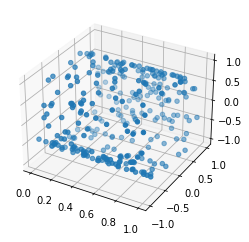

In [7]:
np.random.seed(1) #expand the cylinder into a rectangle and generate 300 points on it and then transform them back
ss3=np.random.uniform(0,2*np.pi,300)
noise=np.random.normal(0,0.1,300) #add noise if you want


noise = 0 #to cancel noise
xx=(1+noise)*np.cos(ss3)
yy=(1+noise)*np.sin(ss3)



rr3=np.random.uniform(0,1,300) #a point (xx,yy,rr3) on 3D
ax = plt.subplot(111, projection='3d')
ax.scatter(rr3,xx,yy) 
X=np.array(np.mat([rr3,xx,yy]).T,dtype=np.float32)
Z=X[:,:2]
plt.show()

In [35]:
def whiten(X):
    return X/tf.math.reduce_std(X,axis=0)

In [100]:
class CustomAccuracy1(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, X, Y):
        
        X = whiten(X)
        Y = whiten(Y)
        
        #X = whiten(X)*(n_samples**(1/X.shape[1]))
#         X = X - tf.math.reduce_mean(X)
        #Y = whiten(Y)*(n_samples**(1/Y.shape[1]))
#         Y = Y - tf.math.reduce_mean(Y)
#         X = (X-tf.math.reduce_mean(X))/tf.math.reduce_std(X,axis=0)
#         Y = (Y-tf.math.reduce_mean(Y))/tf.math.reduce_std(Y,axis=0)
        
        fig, ax = plt.subplots()
        
        ax.scatter(Y.numpy()[:,0],Y.numpy()[:,1])
        plt.show()

        modelR = RipsModel(P=Y, mel=12, dim=1, card = 150)

        #Compute persistence diagram
        Zdgm = modelR.call()[1]
        #sess=tf.compat.v1.InteractiveSession()
        D = Zdgm.numpy()      
        plt.figure()
        plt.scatter(D[:,0], D[:,1], c="blue", alpha=0.8)
        print("D",D)
        Xdgm = modelR.call()[0]
        D1 = Xdgm.numpy()
        plt.scatter(D1[:,0], D1[:,1],c="orange", alpha=0.5)
        line = max(max(D1[:,0]),max(D[:,0]))
        plt.plot([0,line],[0,line])
        plt.show()



        # Loss is Wasserstein distance

        loss = tf.square(wasserstein_distance(Zdgm, Xdgm, order=2, internal_p=2, enable_autodiff=True))


        return loss

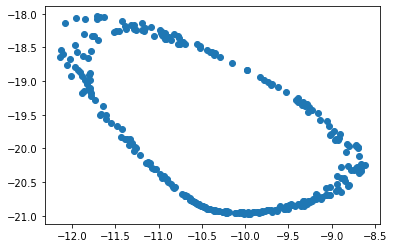

D [[0.21035801 1.8132576 ]
 [0.18438162 0.23580296]
 [0.23188786 0.27554986]
 [0.09407496 0.11822458]
 [0.08907621 0.11158483]
 [0.09882118 0.11770719]
 [0.25024402 0.265625  ]
 [0.15108655 0.16124819]
 [0.11744764 0.12741803]
 [0.13887803 0.1453209 ]
 [0.05524272 0.06051536]
 [0.06151569 0.06629126]
 [0.18814993 0.19247945]
 [0.04941059 0.05182226]
 [0.0927683  0.09342391]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        

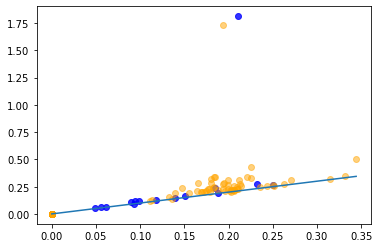

1/1 [==============================] - 6s 6s/step - loss: 0.1294


In [99]:
n_samples = 300
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='ones'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=1,batch_size=n_samples)

# Why does  the Persistance Diagram show no holes???

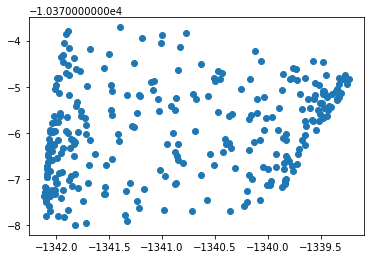

D [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

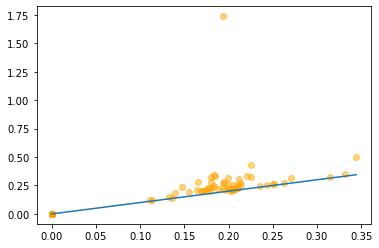

1/1 [==============================] - 6s 6s/step - loss: 1.3262


In [103]:
n_samples = 300
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(2, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=1,batch_size=n_samples)

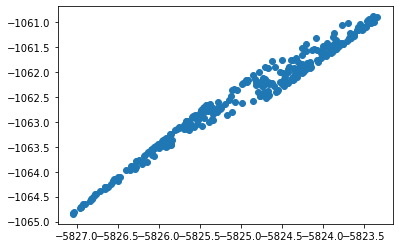

D [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

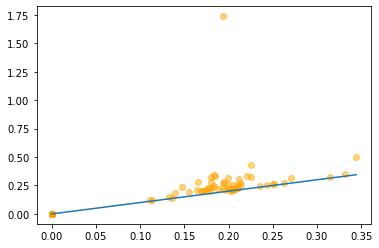

1/1 [==============================] - 6s 6s/step - loss: 1.3262


In [85]:
n_samples = 300
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(2, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=1,batch_size=n_samples)

Epoch 1/6


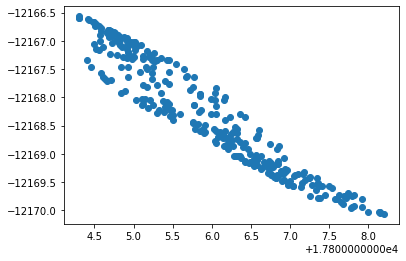

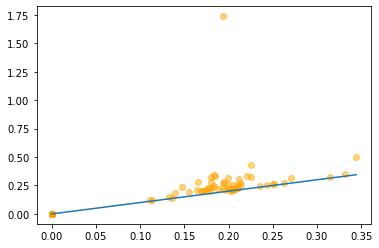

1/1 [==============================] - 6s 6s/step - loss: 1.3262
Epoch 2/6


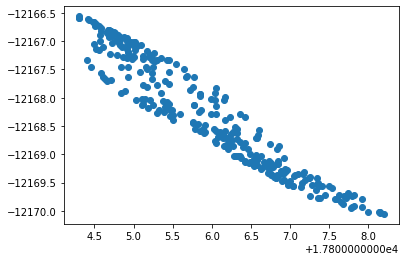

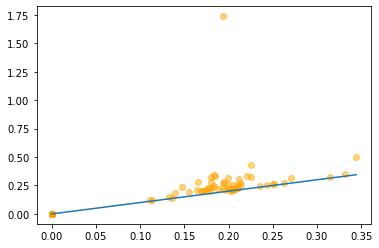

1/1 [==============================] - 6s 6s/step - loss: 1.3262
Epoch 3/6


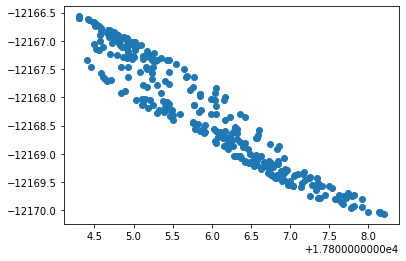

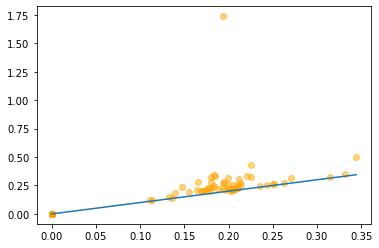

1/1 [==============================] - 6s 6s/step - loss: 1.3262
Epoch 4/6


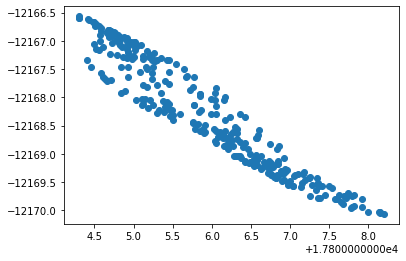

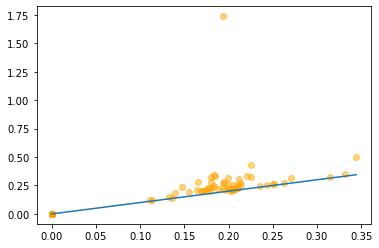

1/1 [==============================] - 6s 6s/step - loss: 1.3262
Epoch 5/6


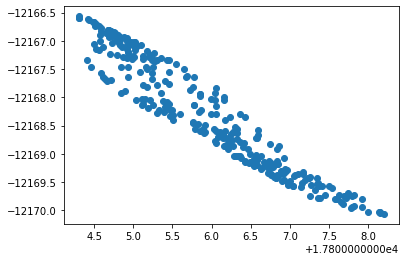

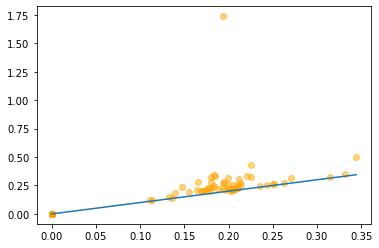

1/1 [==============================] - 6s 6s/step - loss: 1.3262
Epoch 6/6


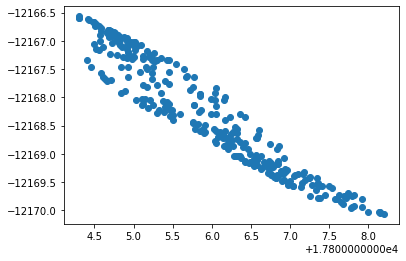

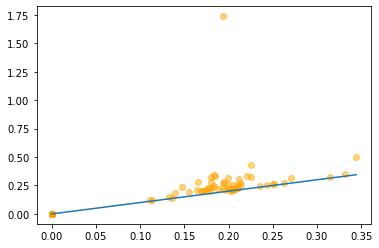

1/1 [==============================] - 6s 6s/step - loss: 1.3262


In [83]:
n_samples = 300
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3, )),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(3, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(2, activation='sigmoid', 
                              kernel_initializer=initializers.RandomNormal(stddev=1), 
                              bias_initializer='zeros'),
        tf.keras.layers.Dense(2)
        ])
model.compile(loss=CustomAccuracy1(),optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01, name='Adam'),run_eagerly=True)
model.fit(X, X,epochs=6,batch_size=n_samples)

In [70]:
model.predict(X)

array([[-0.05635043, -0.7847752 , -0.28158063],
       [-0.03169792, -0.79033065, -0.304     ],
       [ 0.08459167, -0.8077284 , -0.37984282],
       [-0.05121591, -0.792088  , -0.28819776],
       [-0.01391323, -0.80702555, -0.31974518],
       [ 0.04290766, -0.80620915, -0.35284147],
       [ 0.01242726, -0.79639655, -0.32774502],
       [-0.04127249, -0.78684163, -0.29066244],
       [-0.05142316, -0.785102  , -0.28429845],
       [-0.06970122, -0.78316516, -0.27526543],
       [-0.06037255, -0.78527445, -0.279684  ],
       [-0.02475549, -0.7840577 , -0.30363336],
       [ 0.00393548, -0.79501396, -0.3218082 ],
       [ 0.05048904, -0.8051453 , -0.36033076],
       [ 0.03524307, -0.8142625 , -0.3545848 ],
       [-0.03123783, -0.7834083 , -0.2993313 ],
       [-0.05793964, -0.7850028 , -0.28084108],
       [-0.05729984, -0.7813743 , -0.2813711 ],
       [-0.00876566, -0.80720896, -0.32288852],
       [-0.00930479, -0.7981622 , -0.31621844],
       [ 0.0181076 , -0.79668295, -0.336